In [1]:
from params import LocationConfig, TrainingConfig, CreateDataConfig, NetworkConfig
from datamodule import Datamodule
from models.cnn7 import CNN7
from models.cnn8 import CNN8
from models.mlp import MLP, BiggerMLP

from pathlib import Path
from tqdm import tqdm
from glob import glob
import numpy as np
import cv2

import torchvision.transforms as transforms
from torch.nn import functional as F
from torchsummary import summary
import torch

In [2]:
# mlp = MLP(
#         lr=NetworkConfig.lr,
#         batch_norm=NetworkConfig.batch_norm,
#         negative_slope=NetworkConfig.negative_slope,
#         dropout = NetworkConfig.dropout
#         )
# summary(mlp.cuda(), (128,), 16)

cnn7 = CNN8(
        lr=NetworkConfig.lr,
        batch_norm=NetworkConfig.batch_norm,
        negative_slope=NetworkConfig.negative_slope,
        dropout = NetworkConfig.dropout
        )
summary(cnn7.cuda(), (311, 243, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 311, 243]             448
              ReLU-2         [-1, 16, 311, 243]               0
           Dropout-3         [-1, 16, 311, 243]               0
         MaxPool2d-4         [-1, 16, 155, 121]               0
            Conv2d-5         [-1, 32, 155, 121]           4,640
              ReLU-6         [-1, 32, 155, 121]               0
           Dropout-7         [-1, 32, 155, 121]               0
         MaxPool2d-8           [-1, 32, 77, 60]               0
            Conv2d-9           [-1, 64, 77, 60]          18,496
             ReLU-10           [-1, 64, 77, 60]               0
          Dropout-11           [-1, 64, 77, 60]               0
        MaxPool2d-12           [-1, 64, 38, 30]               0
           Conv2d-13          [-1, 128, 38, 30]          73,856
             ReLU-14          [-1, 128,

/home/kkulawiec/.conda/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [4]:
checkpoints_dir = Path(LocationConfig.checkpoints_dir)
list_of_checkpoints = list(checkpoints_dir.glob("*.ckpt"))
latest_checkpoint_path = max(list_of_checkpoints, key=lambda p: p.stat().st_ctime)

cnn4 = CNN4(lr=0.0001, batch_norm=False, dropout=0.2, batch_size=2, negative_slope=0.0)\
    .load_from_checkpoint(checkpoint_path=latest_checkpoint_path)
cnn4.eval();
cnn4.state_dict()['conv.conv_0.weight'][0]

tensor([[[ 0.2577,  0.2794, -0.0790],
         [ 0.3109, -0.0686,  0.0687],
         [-0.1655,  0.1929,  0.2899]]])

In [3]:
train_data_path = Path(LocationConfig.data + 'train')
test_data_path = Path(LocationConfig.data + 'test')
dm = Datamodule(
        batch_size=TrainingConfig.batch_size,
        train_dir=train_data_path,
        val_dir=test_data_path,
        )
# dm.setup(val_only=True)
dm.setup()

file: data/BFD/rgb/train/train.pickle
file: data/BFD/rgb/test/test.pickle


100%|██████████| 2/2 [00:00<00:00, 10.56it/s]


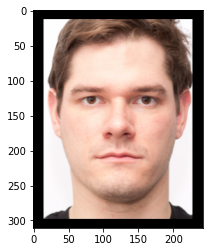

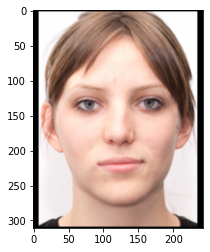

In [4]:
from matplotlib import pyplot as plt
i=0
for batch in tqdm(dm.val_dataloader()):
    image = batch['normalized'][0,:,:]
    plt.figure()
    plt.imshow(cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB))
#     if i == 1:
#         break
#     i+=1

In [5]:
acc_class_global_1 = np.zeros(5)
acc_class_global_12 = np.zeros(5)
i=0
for batch in tqdm(dm.val_dataloader()):
    X, Y = batch['normalized'], batch['label']
    Y_pred = np.zeros_like(Y)#cnn4.predict_step(X, None)
    Y_pred_12 = np.where(Y_pred > 1/2, 1, 0)
    Y_pred_1 = np.ones_like(Y)
    acc_class_12 = np.sum(Y_pred_12 == np.array(Y), axis=0) / len(Y)
    acc_class_1 = np.sum(Y_pred_1 == np.array(Y), axis=0) / len(Y)
    acc_class_global_12 += acc_class_12
    acc_class_global_1 += acc_class_1
    i+=1
acc_class_global_12 /= i
print('1/2')
print(acc_class_global_12)
print(acc_class_global_12.mean())

acc_class_global_1 /= i
print('1')
print(acc_class_global_1)
print(acc_class_global_1.mean())

100%|██████████| 2/2 [00:00<00:00, 12.24it/s]

1/2
[0.25       0.265625   0.23958333 0.265625   0.45833333]
0.2958333333333333
1
[0.75       0.734375   0.76041667 0.734375   0.54166667]
0.7041666666666668


In [6]:
acc_class_global_1 = np.zeros(5)
acc_class_global_12 = np.zeros(5)
i=0
for batch in tqdm(dm.train_dataloader()):
    X, Y = batch['normalized'], batch['label']
    Y_pred = np.zeros_like(Y)#cnn4.predict_step(X, None)
    Y_pred_12 = np.where(Y_pred > 1/2, 1, 0)
    Y_pred_1 = np.ones_like(Y)
    acc_class_12 = np.sum(Y_pred_12 == np.array(Y), axis=0) / len(Y)
    acc_class_1 = np.sum(Y_pred_1 == np.array(Y), axis=0) / len(Y)
    acc_class_global_12 += acc_class_12
    acc_class_global_1 += acc_class_1
    i+=1
acc_class_global_12 /= i
print('1/2')
print(acc_class_global_12)
print(acc_class_global_12.mean())

acc_class_global_1 /= i
print('1')
print(acc_class_global_1)
print(acc_class_global_1.mean())

100%|██████████| 13/13 [00:00<00:00, 22.78it/s]

1/2
[0.36298077 0.31971154 0.28044872 0.40384615 0.35336538]
0.3440705128205128
1
[0.63701923 0.68028846 0.71955128 0.59615385 0.64663462]
0.6559294871794872
